In [1]:
import VariantCalling as vc
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

Prep data to have noisy_images and clean_images numpy arrays with shape (num_samples, height, width, channels)

num_samples: Number of training samples

height: Height of the images

width: Width of the images

channels: Number of color channels (3 for RGB, 1 for grayscale)

# Preping data

In [3]:
dg = vc.VariantCallingData()
noisy, clean = dg.generate_data_for_noise_reduction(sample_size=1, alignment_error_prob=0.002, sequencing_error_prob=0.01)

  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
noisy

array([[[3, 2, 3, ..., 0, 1, 3],
        [3, 2, 3, ..., 0, 1, 3],
        [3, 2, 3, ..., 0, 0, 1],
        ...,
        [3, 2, 3, ..., 0, 1, 3],
        [3, 2, 3, ..., 0, 1, 3],
        [3, 2, 3, ..., 0, 1, 3]]])

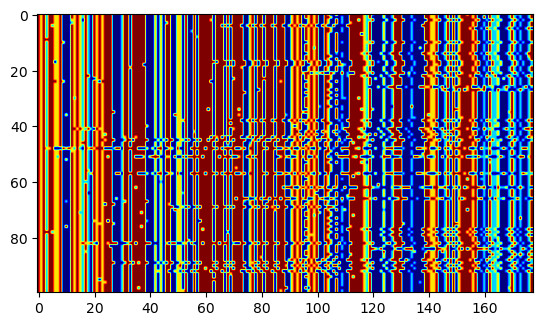

In [5]:
plt.imshow(noisy[0], cmap='jet')

In [6]:
clean

array([[[3, 2, 3, ..., 0, 1, 3],
        [3, 2, 3, ..., 0, 1, 3],
        [3, 2, 3, ..., 0, 1, 3],
        ...,
        [3, 2, 3, ..., 0, 1, 3],
        [3, 2, 3, ..., 0, 1, 3],
        [3, 2, 3, ..., 0, 1, 3]]])

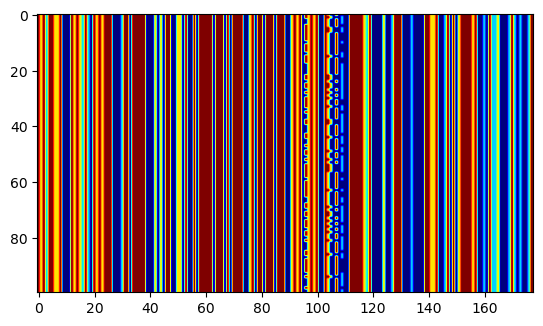

In [7]:
plt.imshow(clean[0], cmap='jet')

In [8]:
if (os.path.exists("pickle/simulated/data_0_1.pkl") and os.path.exists("pickle/simulated/data_0_5.pkl") and os.path.exists("pickle/simulated/data_1_5.pkl") and
    os.path.exists("pickle/simulated/data_01_5.pkl") and os.path.exists("pickle/simulated/data_03_5.pkl") and os.path.exists("pickle/simulated/data_05_5.pkl")):
    print("data exists")
else:
    print("data files are missing, regenerating...\n")
    print("\ngenerating alignment error 0, seq error 0.01")
    data = dg.generate_data_for_noise_reduction(sample_size=15000, alignment_error_prob=0, sequencing_error_prob=0.01)
    with open("pickle/simulated/data_0_1.pkl", "wb") as file:
        pickle.dump(data, file)

    print("\ngenerating alignment error 0, seq error 0.05")
    data = dg.generate_data_for_noise_reduction(sample_size=15000, alignment_error_prob=0, sequencing_error_prob=0.05)
    with open("pickle/simulated/data_0_5.pkl", "wb") as file:
        pickle.dump(data, file)

    print("\ngenerating alignment error 0.001, seq error 0.05")
    data = dg.generate_data_for_noise_reduction(sample_size=30000, alignment_error_prob=0.001, sequencing_error_prob=0.05)
    with open("pickle/simulated/data_01_5.pkl", "wb") as file:
        pickle.dump(data, file)

    print("\ngenerating alignment error 0.003, seq error 0.05")
    data = dg.generate_data_for_noise_reduction(sample_size=30000, alignment_error_prob=0.003, sequencing_error_prob=0.05)
    with open("pickle/simulated/data_03_5.pkl", "wb") as file:
        pickle.dump(data, file)

    print("\ngenerating alignment error 0.005, seq error 0.05")
    data = dg.generate_data_for_noise_reduction(sample_size=30000, alignment_error_prob=0.005, sequencing_error_prob=0.05)
    with open("pickle/simulated/data_05_5.pkl", "wb") as file:
        pickle.dump(data, file)

    print("\ngenerating alignment error 0.01, seq error 0.05")
    data = dg.generate_data_for_noise_reduction(sample_size=30000, alignment_error_prob=0.01, sequencing_error_prob=0.05)
    with open("pickle/simulated/data_1_5.pkl", "wb") as file:
        pickle.dump(data, file)

data files are missing, regenerating...


generating alignment error 0, seq error 0.01


  0%|          | 0/15000 [00:00<?, ?it/s]


generating alignment error 0, seq error 0.05


  0%|          | 0/15000 [00:00<?, ?it/s]


generating alignment error 0.001, seq error 0.05


  0%|          | 0/30000 [00:00<?, ?it/s]


generating alignment error 0.003, seq error 0.05


  0%|          | 0/30000 [00:00<?, ?it/s]


generating alignment error 0.005, seq error 0.05


  0%|          | 0/30000 [00:00<?, ?it/s]


generating alignment error 0.01, seq error 0.05


  0%|          | 0/30000 [00:00<?, ?it/s]

OSError: [Errno 28] No space left on device

# Training

### Loading data with only seq errors

In [103]:
with open("pickle/simulated/data_01_5.pkl", "rb") as file:
    noisy, clean = pickle.load(file)

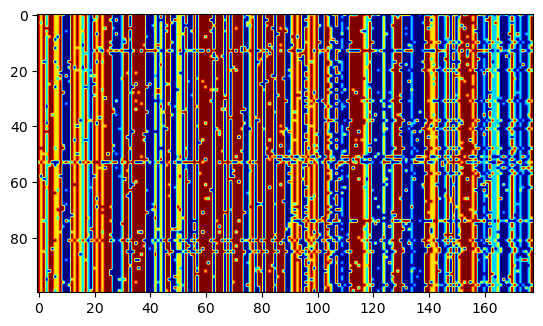

In [104]:
plt.imshow(noisy[0], cmap="jet")

### Normalize the pixel values to [0, 1] and reshape for training

In [105]:
noisy.shape

(30000, 100, 178)

In [106]:
noisy = noisy.astype('float32') / 3
clean = clean.astype('float32') / 3

In [107]:
img_row = 100
img_col = 178
noisy = noisy.reshape(noisy.shape[0], img_row, img_col, 1)
clean = clean.reshape(clean.shape[0], img_row, img_col, 1)

In [108]:
clean.shape

(30000, 100, 178, 1)

In [109]:
noisy.shape

(30000, 100, 178, 1)

### Define and create CNN model

In [110]:
def create_cnn_model(input_shape):
    input_layer = Input(shape=input_shape)

    # Encoder
    encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)

    # Decoder
    decoded = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(encoded)
    decoded = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(decoded)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)

    model = Model(input_layer, decoded)

    return model

In [17]:
input_shape = noisy.shape[1:]  # Excluding the number of samples
input_shape
model = create_cnn_model(input_shape)

2023-08-05 07:53:49.901661: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-05 07:53:49.901930: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-05 07:53:49.901949: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-05 07:53:49.902237: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-05 07:53:49.902950: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
# Compile the model
learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 178, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 178, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 178, 128)     73856     
                                                                 
 conv2d_transpose (Conv2DTr  (None, 100, 178, 128)     147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 100, 178, 64)      73792     
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 178, 1)       577   

In [124]:
# Train the model
batch_size = 32
epochs = 10

model.fit(noisy, clean, batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/3
938/938 [==============================] - 303s 323ms/step - loss: 8.9983e-04
Epoch 2/3
938/938 [==============================] - 305s 325ms/step - loss: 7.5967e-04
Epoch 3/3
938/938 [==============================] - 301s 321ms/step - loss: 6.7303e-04


In [68]:
model2 = create_cnn_model(input_shape)
learning_rate = 0.0001
model2.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 178, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 178, 64)      640       
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 178, 128)     73856     
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 100, 178, 128)     147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 100, 178, 64)      73792     
 Transpose)                                                      
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 178, 1)       577 

In [126]:
denoised_image1 = model.predict(noisy)
denoised_image1_quantised = np.round(denoised_image1 * 3) / 3


938/938 [==============================] - 104s 110ms/step


In [139]:
# Train the model
batch_size = 32
epochs = 2

model2.fit(denoised_image1_quantised, clean, batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/2
517/938 [===============>..............] - ETA: 2:17 - loss: 5.9773e-04

KeyboardInterrupt: 

### Sanity Check

In [140]:
noisy1, clean1 = dg.generate_data_for_noise_reduction(sample_size=1, alignment_error_prob=0.001, sequencing_error_prob=0.05)
noisy1 = noisy1.astype('float32') / 3
clean1 = clean1.astype('float32') / 3
noisy1 = noisy1.reshape(noisy1.shape[0], img_row, img_col, 1)
clean1 = clean1.reshape(clean1.shape[0], img_row, img_col, 1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [141]:
# Load the noisy image (replace 'your_noisy_image_path.jpg' with the actual path to the image)
noisy_image = np.array([noisy1[-1]])

In [142]:
noisy_image.shape

(1, 100, 178, 1)

In [143]:
denoised_image = model.predict(noisy_image)


1/1 [==============================] - 0s 88ms/step


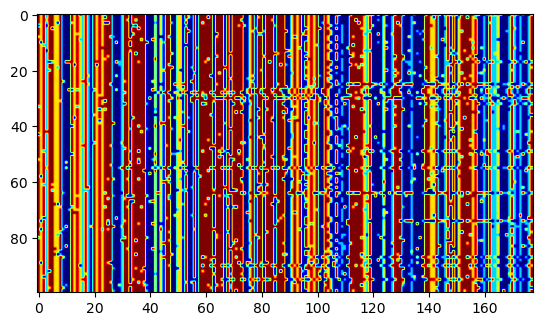

In [144]:
plt.imshow(noisy1[0], cmap='jet')

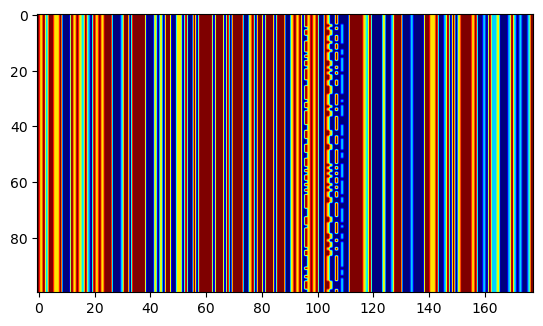

In [145]:
plt.imshow(clean1[0], cmap='jet')

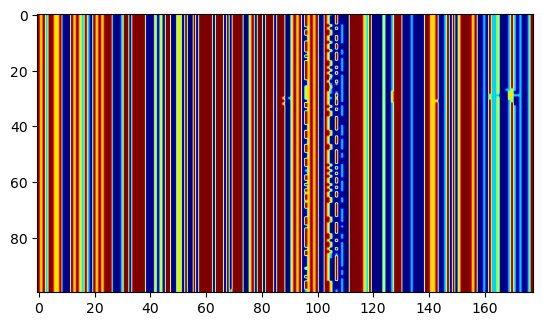

In [146]:
plt.imshow(np.round(denoised_image[0] * 3), cmap='jet')

In [147]:
# plt.imshow(np.round(denoised_image[0] * 3), cmap='jet')
denoised_image2 = model2.predict(np.round(np.array([denoised_image[0]]) * 3) / 3)

1/1 [==============================] - 0s 25ms/step


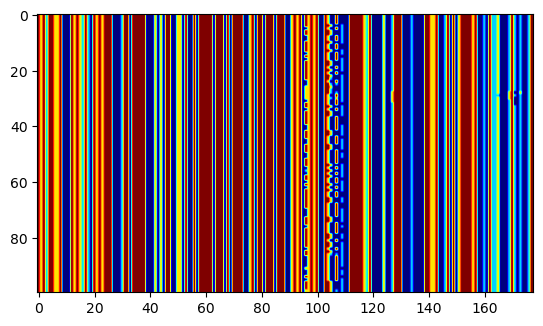

In [148]:
plt.imshow(np.round(denoised_image2[0] * 3), cmap="jet")

In [149]:
clone_1  = dg.char_to_int(dg.clones[0])
clone_2  = dg.char_to_int(dg.clones[1])
clone_3  = dg.char_to_int(dg.clones[2])

# np.round(denoised_image2[0] * 3).reshape(100,178)

In [150]:
reshaped_test_data = np.round(denoised_image2[0] * 3).reshape(100,178)

In [151]:
clone_counter = [0,0,0,0,]
for row in reshaped_test_data:
    if (row == clone_1).all():
        clone_counter[0] += 1
    elif (row == clone_2).all():
        clone_counter[1] += 1
    elif (row == clone_3).all():
        clone_counter[2] += 1
    else:
        clone_counter[3] += 1

clone_counter

[25, 32, 29, 14]

In [152]:
model.save('model1')

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


In [153]:
model2.save('model2')

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets
